### This solution is inspired by [Alexandru Papiu](https://www.kaggle.com/code/apapiu/regularized-linear-models), [Serigne](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook) and [Lavanya Shukla](https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/notebook)

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Imports & EDA

In [2]:
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train = train_data
test = test_data

train_test_data = pd.concat([train, test],axis=0,ignore_index=True)
train_test_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


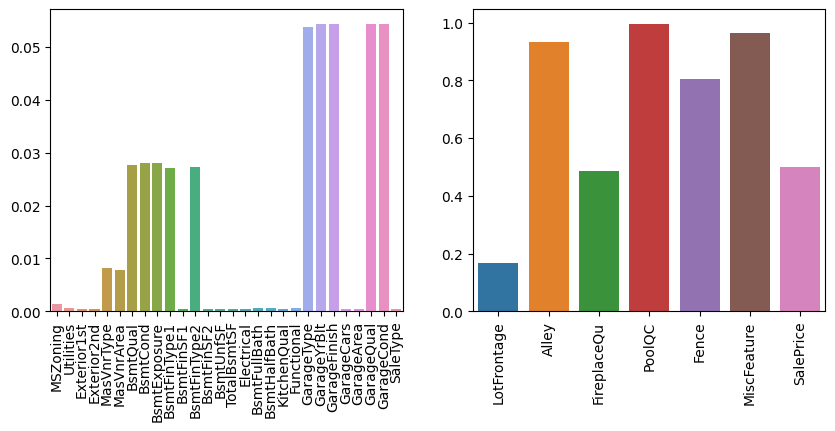

In [3]:
# Missing ratio of each feature
missing_ratio = train_test_data.isnull().sum() / len(train_test_data)
missing_ratio = missing_ratio[missing_ratio.values>0]
missing_ratio_low = missing_ratio[missing_ratio.values<=0.1]
missing_ratio_high = missing_ratio[missing_ratio.values>0.1]

fig = plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
sns.barplot(x=missing_ratio_low.index,y=missing_ratio_low.values)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.barplot(x=missing_ratio_high.index,y=missing_ratio_high.values)
plt.xticks(rotation=90);

<AxesSubplot:>

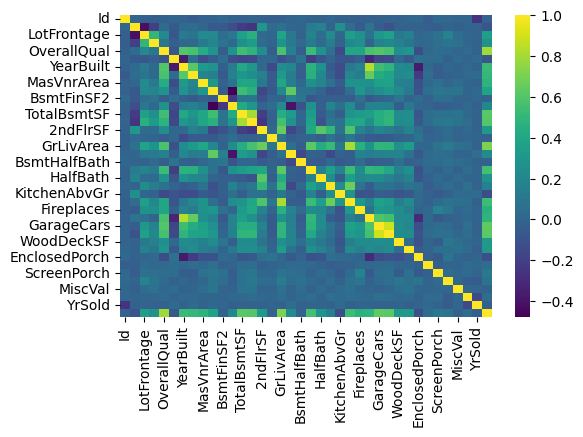

In [4]:
fig = plt.figure(figsize=(6,4),dpi=100)
sns.heatmap(train_test_data.corr(),cmap='viridis')

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

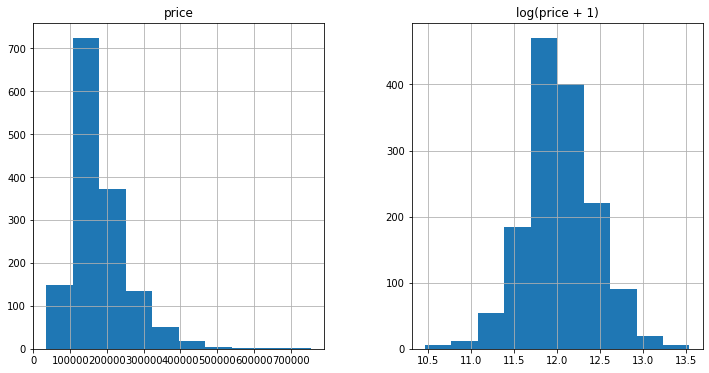

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

### Feature Engineering

In [6]:
# Fill in missing rows
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda val: val.fillna(val.mean()))
train['MiscFeature'] = train['MiscFeature'].replace(to_replace=['Gar2','Othr','TenC'],value='Other')
train['MiscFeature'] = train['MiscFeature'].fillna(value='Other')

test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda val: val.fillna(val.mean()))
test['MiscFeature'] = test['MiscFeature'].replace(to_replace=['Gar2','Othr','TenC'],value='Other')
test['MiscFeature'] = test['MiscFeature'].fillna(value='Other')

# Drop some features with high missing ratio
train = train.drop(['Alley','FireplaceQu','PoolQC','Fence'],axis=1)
test = test.drop(['Alley','FireplaceQu','PoolQC','Fence'],axis=1)

# Fill in missing rows
train['MSZoning'] = train['MSZoning'].fillna(value='RL')
train['Exterior1st'] = train['Exterior1st'].fillna(value='VinylSd')
train['Exterior2nd'] = train['Exterior2nd'].fillna(value='VinylSd')
train['MasVnrType'] = train['MasVnrType'].fillna(value='None')
train['MasVnrArea'] = train['MasVnrArea'].fillna(value=0)
train[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = train[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='None')
train[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = train[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(value=0)
train['Electrical'] = train['Electrical'].fillna(value='SBrkr')
train['KitchenQual'] = train['KitchenQual'].fillna(value='TA')
train['Functional'] = train['Functional'].fillna(value='Typ')
train[['GarageType','GarageFinish','GarageQual','GarageCond']] = train[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='None')
train[['GarageYrBlt','GarageCars','GarageArea']] = train[['GarageYrBlt','GarageCars','GarageArea']].fillna(value=0)
train['SaleType'] = train['SaleType'].fillna(value='WD')

test['MSZoning'] = test['MSZoning'].fillna(value='RL')
test['Exterior1st'] = test['Exterior1st'].fillna(value='VinylSd')
test['Exterior2nd'] = test['Exterior2nd'].fillna(value='VinylSd')
test['MasVnrType'] = test['MasVnrType'].fillna(value='None')
test['MasVnrArea'] = test['MasVnrArea'].fillna(value=0)
test[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = test[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='None')
test[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = test[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(value=0)
test['Electrical'] = test['Electrical'].fillna(value='SBrkr')
test['KitchenQual'] = test['KitchenQual'].fillna(value='TA')
test['Functional'] = test['Functional'].fillna(value='Typ')
test[['GarageType','GarageFinish','GarageQual','GarageCond']] = test[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='None')
test[['GarageYrBlt','GarageCars','GarageArea']] = test[['GarageYrBlt','GarageCars','GarageArea']].fillna(value=0)
test['SaleType'] = test['SaleType'].fillna(value='WD')

# Drop some features
train = train.drop(['Utilities','Id'],axis=1)
test = test.drop(['Utilities','Id'],axis=1)

In [7]:
# Data Scaling

# Log transform the target
train['SalePrice'] = np.log1p(train['SalePrice'])

# Log/BoxCox transform skewed numeric features
numeric_feats = test.dtypes[test.dtypes != "object"].index

skewed_feats = test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# train_test_data[skewed_feats] = np.log1p(train_test_data[skewed_feats])
lam = 0.15
for feat in skewed_feats:
    train[feat] = boxcox1p(train[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)

In [8]:
y = train['SalePrice']
train = train.drop('SalePrice',axis=1)

train_test_data = pd.concat([train, test],axis=0,ignore_index=True)
train_test_data = pd.get_dummies(train_test_data,drop_first=True)

X = train_test_data.iloc[:1460]
X_submission = train_test_data.iloc[1460:]

### Modeling

In [9]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [10]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [11]:
# Get cross validation scores for each model
scores = {}

# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['lgb'] = (score.mean(), score.std())

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['xgb'] = (score.mean(), score.std())

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

# score = cv_rmse(ridge)
# print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['ridge'] = (score.mean(), score.std())

# score = cv_rmse(rf)
# print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['rf'] = (score.mean(), score.std())

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['gbr'] = (score.mean(), score.std())

In [12]:
# Fit the models
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('RandomForest')
rf_model_full_data = rf.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

stack_gen
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warn

In [13]:
# Plot the scores for each model
# sns.set_style("white")
# fig = plt.figure(figsize=(10, 5))

# ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
# for i, score in enumerate(scores.values()):
#     ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

# plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
# plt.xlabel('Model', size=20, labelpad=12.5)
# plt.tick_params(axis='x', labelsize=13.5)
# plt.tick_params(axis='y', labelsize=12.5)

# plt.title('Scores of Models', size=20)

# plt.show()

In [14]:
# Blend models in order to make the final predictions more robust to overfitting

# Submission V1: blended model without Stacking Regressor
# def blended_predictions(X):
#     return ((0.2 * ridge_model_full_data.predict(X)) + \
#             (0.2 * svr_model_full_data.predict(X)) + \
#             (0.2 * gbr_model_full_data.predict(X)) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
#             (0.2 * lgb_model_full_data.predict(X)) + \
#             (0.1 * rf_model_full_data.predict(X)))

# Submission V2: blended model with Stacking Regressor
# def blended_predictions(X):
#     return ((0.1 * ridge_model_full_data.predict(X)) + \
#             (0.2 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.05 * rf_model_full_data.predict(X)) + \
#             (0.35 * stack_gen_model.predict(np.array(X))))

# Submission V3: blended model with Stacking Regressor
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.05 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.50 * stack_gen_model.predict(np.array(X))))

blended_score = rmsle(y, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.08187490296325851


In [15]:
# Read in sample_submission dataframe
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_submission)))

# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("submission_v3.csv", index=False)